Final check for NaN values before mutual_info_regression:
 tempmin                                                                    0
temp                                                                       0
feelslikemax                                                               0
feelslikemin                                                               0
feelslike                                                                  0
                                                                          ..
conditions_Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy    0
conditions_Snow, Rain, Ice, Overcast                                       0
conditions_Snow, Rain, Ice, Partially cloudy                               0
conditions_Snow, Rain, Overcast                                            0
conditions_Snow, Rain, Partially cloudy                                    0
Length: 67, dtype: int64

Mutual Information Scores:
feelslikemax                             

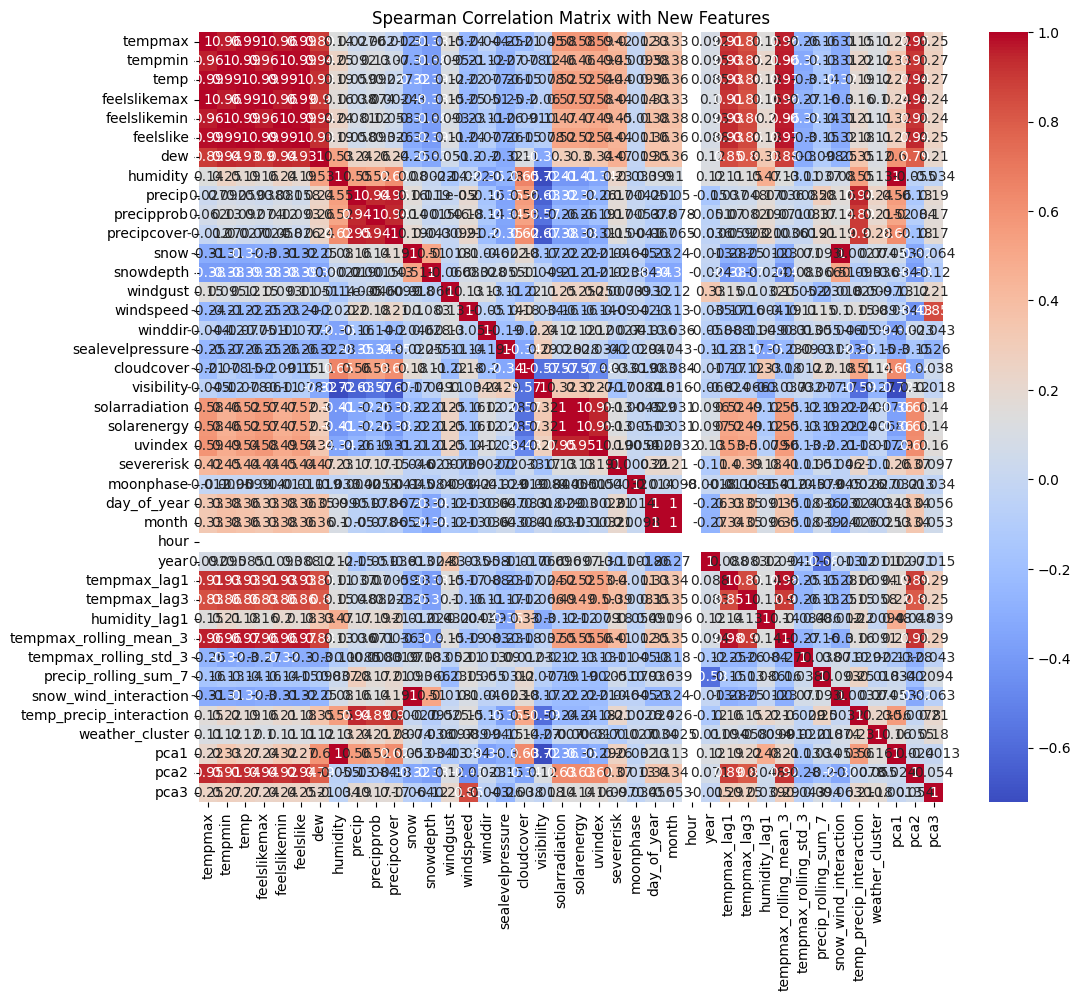

Enhanced dataset saved to C:\Users\June Nguyen\AI_asm2\preprocessing\enhanced_data.csv


In [11]:
# Feature Engineering and Pattern Analysis Notebook
# Filename: feature_engineering.ipynb

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb

# Load the Dataset
file_path = r"C:\Users\June Nguyen\AI_asm2\data\NewYork.csv"
data = pd.read_csv(file_path)

# 1. Handle DateTime
# Convert 'datetime' column to datetime type and extract useful components
data['datetime'] = pd.to_datetime(data['datetime'])
data['day_of_year'] = data['datetime'].dt.dayofyear
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year

# Drop the original 'datetime' column as it's no longer needed
data = data.drop(columns=['datetime'])

# 2. Drop Unnecessary Columns
# Remove columns that are not expected to have a significant impact on temperature
columns_to_drop = ['name', 'stations', 'icon', 'description', 'sunrise', 'sunset']
data = data.drop(columns=columns_to_drop)

# 3. Handle Missing Values for Categorical Features
# Fill missing values in 'preciptype' with 'unknown'
data['preciptype'] = data['preciptype'].fillna('unknown')

# 4. Handle Missing Values for Numeric Features
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# 5. Lag Features
data['tempmax_lag1'] = data['tempmax'].shift(1)
data['tempmax_lag3'] = data['tempmax'].shift(3)
data['humidity_lag1'] = data['humidity'].shift(1)

# 6. Rolling Statistics
data['tempmax_rolling_mean_3'] = data['tempmax'].rolling(window=3).mean()
data['tempmax_rolling_std_3'] = data['tempmax'].rolling(window=3).std()
data['precip_rolling_sum_7'] = data['precip'].rolling(window=7).sum()

# Handle any new NaN values that may have been introduced by lag or rolling operations
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# 7. Interaction Terms
data['snow_wind_interaction'] = data['snow'] * data['windspeed']
data['temp_precip_interaction'] = data['temp'] * data['precip']

# 8. Clustering Weather Patterns
kmeans = KMeans(n_clusters=5, random_state=42)
data['weather_cluster'] = kmeans.fit_predict(data[['temp', 'humidity', 'windspeed', 'precip']])

# 9. Dimensionality Reduction (PCA)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data[['temp', 'humidity', 'windspeed', 'precip']])
data['pca1'] = principal_components[:, 0]
data['pca2'] = principal_components[:, 1]
data['pca3'] = principal_components[:, 2]

# 10. Encode Categorical Features
data_encoded = pd.get_dummies(data, columns=['preciptype', 'conditions'], drop_first=True)

# 11. Final Check and Handle Remaining NaN Values
# Drop any remaining NaN values that could cause issues
data_encoded = data_encoded.dropna()

# 12. Mutual Information
X = data_encoded.drop(columns=['tempmax'])
y = data_encoded['tempmax']

# Final check to ensure no NaNs remain before mutual_info_regression
print("Final check for NaN values before mutual_info_regression:\n", X.isnull().sum())

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print("\nMutual Information Scores:")
print(mi_series)

# 13. Feature Importance using XGBoost
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost_model.fit(X, y)
importance = xgboost_model.feature_importances_
importance_series = pd.Series(importance, index=X.columns).sort_values(ascending=False)

print("\nXGBoost Feature Importances:")
print(importance_series)

# 14. Correlation Matrix with Spearman Rank Correlation
numeric_columns = data_encoded.select_dtypes(include=[np.number])
spearman_corr_matrix = numeric_columns.corr(method='spearman')

print("Spearman Correlation Matrix with New Features:\n", spearman_corr_matrix['tempmax'])

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix with New Features')
plt.show()

# 15. Save the Enhanced Dataset
enhanced_data_path = r"C:\Users\June Nguyen\AI_asm2\preprocessing\enhanced_data.csv"
data_encoded.to_csv(enhanced_data_path, index=False)

print(f"Enhanced dataset saved to {enhanced_data_path}")
